In [1]:
import pymc as pm
import numpy as np
import scipy as sp
from numpy.random import default_rng
import matplotlib.pyplot as plt
import arviz as az

Could not locate executable g77
Could not locate executable f77
Could not locate executable ifort
Could not locate executable ifl
Could not locate executable f90
Could not locate executable efl


In [43]:
n_samples = 1000

In [57]:
rng = default_rng(seed=0)

lam = 1.5
k = 1
X = np.zeros((n_samples, 1))
y_time = sp.stats.weibull_min.rvs(c=k, scale=np.exp(lam), size=(n_samples)).T.flatten()
y_event = y_time < 10 #rng.choice([1, 0], size=(n_samples), p=[0.5, 0.5]).astype(np.int_)
y = np.vstack((y_time, y_event)).T


(array([38., 21., 16.,  7.,  6.,  5.,  1.,  3.,  3.,  2.]),
 array([10.02833955, 11.75692391, 13.48550826, 15.21409261, 16.94267696,
        18.67126131, 20.39984566, 22.12843001, 23.85701436, 25.58559872,
        27.31418307]),
 <BarContainer object of 10 artists>)

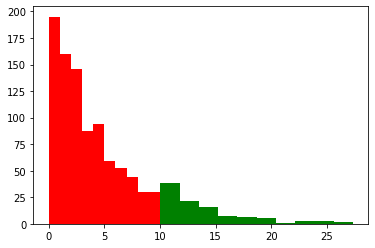

In [58]:
plt.hist(y_time[y_event], color='red')
plt.hist(y_time[~y_event], color='green')


In [45]:
print(X.shape, y.shape)

(1000, 1) (1000, 2)


In [59]:
censor = (y[:, 1] == 0)
time = y[:, 0]
print(np.min(time), np.max(time))

print(X.dtype)
print(y.dtype)
print(time.dtype, time.shape)
print(censor.dtype, censor.shape)

model = pm.Model()

with model:
    lambda_intercept = pm.Normal("lambda_intercept", mu=0, sigma=10, shape=(1,))
    k_intercept = pm.Normal('k_intercept', mu=0, sigma=10, shape=(1,))

    lambda_ = pm.Deterministic("lambda_", pm.math.exp(lambda_intercept + (0 * X).sum(axis=1)))
    k_ = pm.Deterministic("k_", pm.math.exp(k_intercept + (0 * X).sum(axis=1)))
    print(k_.shape.eval(), lambda_.shape.eval(), time.shape)

    y_uncens = pm.Weibull("y", alpha=k_[~censor], beta=lambda_[~censor], observed=time[~censor])

    def weibull_lccdf(x, alpha, beta):
        """ Log complementary cdf of Weibull distribution. """
        return -((x / beta) ** alpha)

    y_cens = pm.Potential("y_cens", weibull_lccdf(time[censor], alpha=k_[censor], beta=lambda_[censor]))

    trace = pm.sample(draws=2000, target_accept=0.85, chains=2, cores=1)

summary = az.summary(trace, var_names=["lambda_coefs", "lambda_intercept", "k_intercept", 'k_coefs'], filter_vars='like')

0.002230758373541188 27.314183066815076
float64
float64
float64 (1000,)
bool (1000,)
[1000] [1000] (1000,)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lambda_intercept, k_intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 30 seconds.


In [62]:
print(summary)

                      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
lambda_intercept[0]  1.559  0.037   1.487    1.628      0.001      0.0   
k_intercept[0]      -0.101  0.026  -0.151   -0.052      0.000      0.0   

                     ess_bulk  ess_tail  r_hat  
lambda_intercept[0]    3912.0    2762.0    1.0  
k_intercept[0]         4169.0    2959.0    1.0  


In [64]:
summary['mean']['lambda_intercept[0]']

1.559

(1000, 1) (1000, 2)


(array([249., 121.,  62.,  25.,  26.,   9.,   2.,   4.,   0.,   2.]),
 array([4.86271385e-03, 1.76052045e+00, 3.51617819e+00, 5.27183593e+00,
        7.02749367e+00, 8.78315141e+00, 1.05388091e+01, 1.22944669e+01,
        1.40501246e+01, 1.58057824e+01, 1.75614401e+01]),
 <BarContainer object of 10 artists>)

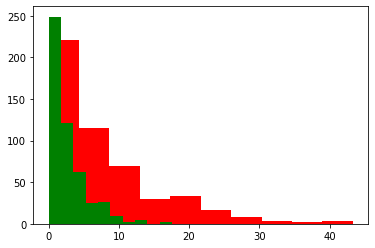

In [99]:
rng = default_rng(seed=0)

lam_trt = 2
lam_ctrl = 1
k = 1

X = np.stack((np.zeros((int(n_samples/2))), np.ones((int(n_samples/2))))).flatten()
X = np.expand_dims(X, axis=1)
y_time_trt = sp.stats.weibull_min.rvs(c=np.exp(k), scale=np.exp(lam_trt), size=int(n_samples/2)).T.flatten()
y_time_ctrl = sp.stats.weibull_min.rvs(c=np.exp(k), scale=np.exp(lam_ctrl), size=int(n_samples/2)).T.flatten()
y_time = np.stack((y_time_ctrl, y_time_trt)).flatten()

y_event = y_time < 15 #rng.choice([1, 0], size=(n_samples), p=[0.5, 0.5]).astype(np.int_)
y = np.vstack((y_time, y_event)).T
print(X.shape, y.shape)

plt.hist(y_time[X[:,0]==1], color='red')
plt.hist(y_time[X[:,0]==0], color='green')


In [100]:
censor = (y[:, 1] == 0)
time = y[:, 0]
print(np.min(time), np.max(time))

print(X.dtype, X.shape)
print(y.dtype)
print(time.dtype, time.shape)
print(censor.dtype, censor.shape)

model = pm.Model()

with model:
    lambda_intercept = pm.Normal("lambda_intercept", mu=0, sigma=10, shape=(1,))
    k_intercept = pm.Normal('k_intercept', mu=0, sigma=10, shape=(1,))

    lambda_coefs = pm.Normal('lambda_coefs',
                                     mu=0,
                                     sigma=1, shape=(1,))
    
    lambda_ = pm.Deterministic("lambda_", pm.math.exp(lambda_intercept + (lambda_coefs * X).sum(axis=1)))
    k_ = pm.Deterministic("k_", pm.math.exp(k_intercept + (0 * X).sum(axis=1)))
    print(k_.shape.eval(), lambda_.shape.eval(), time.shape)

    y_uncens = pm.Weibull("y", alpha=k_[~censor], beta=lambda_[~censor], observed=time[~censor])

    def weibull_lccdf(x, alpha, beta):
        """ Log complementary cdf of Weibull distribution. """
        return -((x / beta) ** alpha)

    y_cens = pm.Potential("y_cens", weibull_lccdf(time[censor], alpha=k_[censor], beta=lambda_[censor]))

    trace = pm.sample(draws=2000, target_accept=0.85, chains=2, cores=1)

summary = az.summary(trace, var_names=["lambda_coefs", "lambda_intercept", "k_intercept", 'k_coefs'], filter_vars='like')

0.004862713846071458 43.32880006546485
float64 (1000, 1)
float64
float64 (1000,)
bool (1000,)
[1000] [1000] (1000,)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lambda_intercept, k_intercept, lambda_coefs]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 45 seconds.


In [101]:
print(summary)

                      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
lambda_intercept[0]  0.924  0.051   0.827    1.021      0.001    0.001   
k_intercept[0]      -0.122  0.026  -0.172   -0.073      0.001    0.000   
lambda_coefs[0]      1.233  0.074   1.102    1.378      0.001    0.001   

                     ess_bulk  ess_tail  r_hat  
lambda_intercept[0]    2424.0    2384.0    1.0  
k_intercept[0]         2639.0    2654.0    1.0  
lambda_coefs[0]        2544.0    2622.0    1.0  


In [107]:
y[[0, 99], 1]

array([1., 1.])

In [108]:
y

array([[ 4.28737134,  1.        ],
       [16.6668891 ,  0.        ],
       [ 0.32351048,  1.        ],
       ...,
       [ 1.01699514,  1.        ],
       [11.62230031,  1.        ],
       [ 0.21281927,  1.        ]])

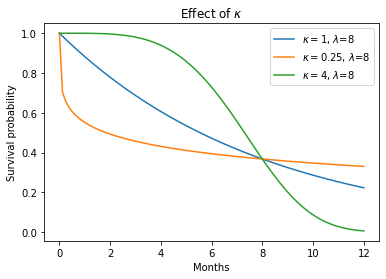

In [26]:
t = np.linspace(0, 12, 100)

S0 = sp.stats.weibull_min.sf

plt.plot(t, S0(t, c=1, scale=8), label = f"$\kappa=1$, $\lambda$=8");
plt.plot(t, S0(t, c=0.25, scale=8), label = f"$\kappa=0.25$, $\lambda$=8");
plt.plot(t, S0(t, c=4, scale=8), label = f"$\kappa=4$, $\lambda$=8");
plt.ylabel("Survival probability")
plt.xlabel("Months")
plt.title("Effect of $\kappa$")
plt.legend();


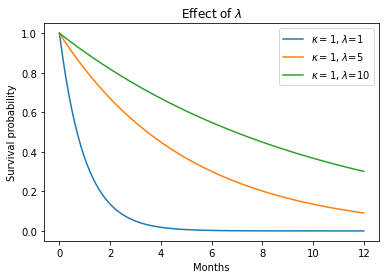

In [25]:
t = np.linspace(0, 12, 100)

S0 = sp.stats.weibull_min.sf

plt.plot(t, S0(t, c=1, scale=1), label = f"$\kappa=1$, $\lambda$=1");
plt.plot(t, S0(t, c=1, scale=5), label = f"$\kappa=1$, $\lambda$=5");
plt.plot(t, S0(t, c=1, scale=10), label = f"$\kappa=1$, $\lambda$=10");
plt.ylabel("Survival probability")
plt.xlabel("Months")
plt.title("Effect of $\lambda$")
plt.legend();

array([ 0.        ,  0.12121212,  0.24242424,  0.36363636,  0.48484848,
        0.60606061,  0.72727273,  0.84848485,  0.96969697,  1.09090909,
        1.21212121,  1.33333333,  1.45454545,  1.57575758,  1.6969697 ,
        1.81818182,  1.93939394,  2.06060606,  2.18181818,  2.3030303 ,
        2.42424242,  2.54545455,  2.66666667,  2.78787879,  2.90909091,
        3.03030303,  3.15151515,  3.27272727,  3.39393939,  3.51515152,
        3.63636364,  3.75757576,  3.87878788,  4.        ,  4.12121212,
        4.24242424,  4.36363636,  4.48484848,  4.60606061,  4.72727273,
        4.84848485,  4.96969697,  5.09090909,  5.21212121,  5.33333333,
        5.45454545,  5.57575758,  5.6969697 ,  5.81818182,  5.93939394,
        6.06060606,  6.18181818,  6.3030303 ,  6.42424242,  6.54545455,
        6.66666667,  6.78787879,  6.90909091,  7.03030303,  7.15151515,
        7.27272727,  7.39393939,  7.51515152,  7.63636364,  7.75757576,
        7.87878788,  8.        ,  8.12121212,  8.24242424,  8.36